In [119]:
# --- 1. Imports & Constants

import numpy as np
import matplotlib.pyplot as plt

# Physical constants
c     = 0.3          # m/ns
n_ref = 1.33         # refractive index of water

# Simulation knobs
I_0 = 3 * 1e7            # arbitrary initial intensity scale factor
L_max     = 2000.0   # m, max muon travel
L_att     = 100.0     # m, attenuation length
I_thresh  = 0.01     # relative intensity cutoff
# Poisson pseudo-data knobs (used as defaults)
E_TOTAL = 50_000   # total expected counts per event (tune as you like)
K_MIN   = 1        # min counts to accept a DOM as "detected"

# --- Muon Track in 3D ---
# Start point (x, y, z)
x0 = np.array([-600.0, 0.0, 0.0])

# Direction parameterized by spherical coordinates (zenith, azimuth)
muon_zenith_deg = 120.0
muon_azimuth_deg = 45.0
theta_dir = np.deg2rad(muon_zenith_deg)
phi_dir = np.deg2rad(muon_azimuth_deg)

# 3D unit direction vector u = (ux, uy, uz)
u = np.array([
    np.sin(theta_dir) * np.cos(phi_dir),
    np.sin(theta_dir) * np.sin(phi_dir),
    np.cos(theta_dir)
])

# --- Derived Cherenkov Quantities ---
β      = 1.0  # Assuming relativistic muon
theta_C = np.arccos(1 / (n_ref * β))
sin_C = np.sin(theta_C)
tan_C = np.tan(theta_C)


In [120]:
# Build DOM positions
n_dom_x = n_dom_y = n_dom_z = 15
spacing = 75.0
xs = (np.arange(n_dom_x) - (n_dom_x - 1) / 2) * spacing
ys = (np.arange(n_dom_y) - (n_dom_y - 1) / 2) * spacing
zs = (np.arange(n_dom_z) - (n_dom_z - 1) / 2) * spacing
DOM_positions = np.stack(np.meshgrid(xs, ys, zs), axis=-1).reshape(-1, 3)


In [121]:
def perp_distance(x0, u, x_dom):
    v = x_dom - x0
    proj = np.dot(v, u)*u
    return np.linalg.norm(v - proj)

def intensity(r_perp, L_att=L_att, sC=sin_C, I0=I_0, d_floor=5.0):
    """
    Physically: I ∝ exp(-d/L_att) / d^2, where d = r_perp / sinC.
    Numerically: clamp d with a floor to avoid gigantic sizes.
    """
    d = r_perp / sC
    d_eff = max(d, d_floor)           # <- clamp near-field
    I = I0 * np.exp(-d / L_att) / (d_eff**2)
    return I

def arrival_time(s0, r_perp, c=c, n=n_ref, sinC=sin_C, tanC=tan_C):
    
    # Time for muon to reach the point of closest approach (s0)
    t_mu_ca = s0 / c
    
    # Distance along track from closest approach to the emission point
    d_along_track = r_perp / tanC
    
    # Time for muon to travel this extra distance
    t_mu_extra = d_along_track / c

    # Time for photon to travel from emission point to DOM
    d_photon = r_perp / sinC
    t_ph = n * d_photon / c
    
    return (t_mu_ca - t_mu_extra) + t_ph



In [122]:
hits = []
for idx, x_dom in enumerate(DOM_positions):
    v = x_dom - x0
    s0 = np.dot(v, u)                    # path‐parameter of closest approach
    if not (0 <= s0 <= L_max):
        continue

    r_perp = perp_distance(x0, u, x_dom)
    d_along_track = r_perp / tan_C
    s_emit = s0 - d_along_track # Position of emission along the track
    if not (0 <= s_emit <= L_max):
        continue
    I = intensity(r_perp)
    if I < I_thresh:
        continue

    t = arrival_time(s0, r_perp) + np.random.normal(0, 2.5)  # add some jitter
    hits.append((idx, t, I))


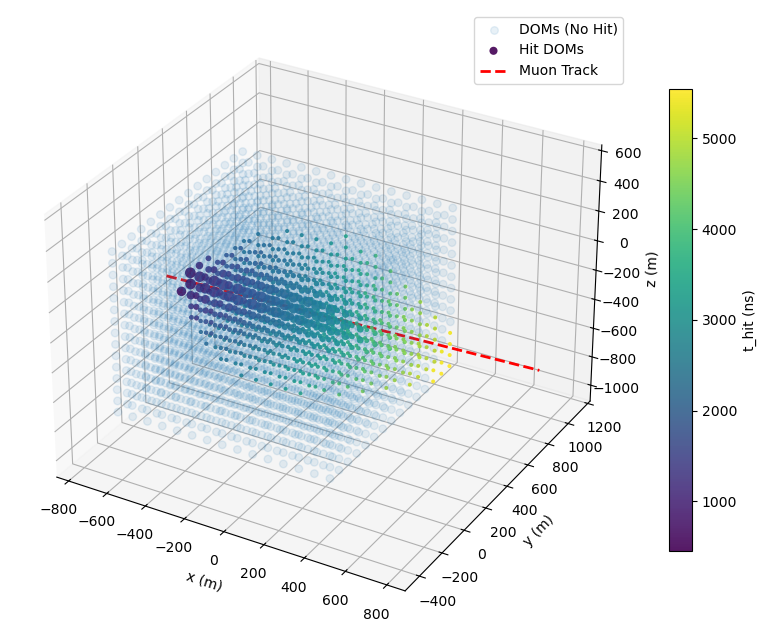

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# --- 3D Visualization ---

# Check if there are any hits to plot
if not hits:
    print("No hits were recorded. Cannot generate plot.")
else:
    # Unpack hits (this part is already 3D-compatible)
    idxs, times, ints = zip(*hits)
    hit_pts = DOM_positions[list(idxs)]

    # Compute non-hit DOMs
    all_idxs = np.arange(len(DOM_positions))
    non_hit_idxs = np.setdiff1d(all_idxs, list(idxs))
    non_pts = DOM_positions[non_hit_idxs]

    # Prepare the muon track line for plotting
    track_line = np.vstack((x0, x0 + L_max * u))

    # --- Create a 3D Plot ---
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    # --- Robust size mapping for plotting only (no physics change) ---
    ints = np.array(ints, dtype=float)

    # Handle inf/NaN safely (for plotting only)
    finite = np.isfinite(ints)
    if not finite.all():
        # set non-finite to a high but finite value so they get clipped
        ints[~finite] = np.nanmax(ints[finite]) if finite.any() else 0.0

    # Clip extreme values so a few huge hits don't dominate the scene
    hi = np.nanpercentile(ints, 98.0) if np.isfinite(ints).any() else 1.0
    ints_clipped = np.clip(ints, 0.0, hi)

    # Smooth dynamic range: size ∝ sqrt(intensity)
    s_min, s_max = 8.0, 60.0
    sizes = s_min + (s_max - s_min) * np.sqrt(ints_clipped / (hi + 1e-12))

    # Plot all DOMs with low opacity
    ax.scatter(non_pts[:, 0], non_pts[:, 1], non_pts[:, 2], s=30, alpha=0.1, label='DOMs (No Hit)')

    # Plot hit DOMs, sized by intensity and colored by time
    # Note the addition of the z-coordinate: hit_pts[:, 2]
    sc = ax.scatter(
        hit_pts[:, 0], hit_pts[:, 1], hit_pts[:, 2],
        s=sizes,               # <-- use the capped sizes
        c=times, cmap='viridis',
        alpha=0.9, edgecolors='none', depthshade=False,
        label='Hit DOMs'
)

    
    # Plot the muon track
    # Note the addition of the z-coordinate: track_line[:, 2]
    ax.plot(track_line[:, 0], track_line[:, 1], track_line[:, 2], 'r--', lw=2, label='Muon Track')

    # Colorbar for timing
    cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
    cbar.set_label('t_hit (ns)')

    # --- Formatting for 3D ---
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')
    ax.legend()
    
    # Set aspect ratio to be equal
    all_pts = np.vstack([DOM_positions, track_line])
    min_coords = all_pts.min(axis=0)
    max_coords = all_pts.max(axis=0)
    mid_coords = (min_coords + max_coords) / 2
    max_range = (max_coords - min_coords).max() / 2
    ax.set_xlim(mid_coords[0] - max_range, mid_coords[0] + max_range)
    ax.set_ylim(mid_coords[1] - max_range, mid_coords[1] + max_range)
    ax.set_zlim(mid_coords[2] - max_range, mid_coords[2] + max_range)

    plt.show()

In [124]:
print(hits)

[(1581, 470.2911213656255, 1125.67927213026), (1594, 1193.612017937701, 28.332232933152575), (1595, 939.1451574967425, 104.21171389748196), (1596, 747.0058465746497, 226.78261399743988), (1608, 1661.3974527357534, 5.882646009689996), (1609, 1407.5479980817956, 17.15125409334009), (1610, 1199.8677265414933, 37.259578683143275), (1621, 2398.4781569512206, 0.48265943547231893), (1622, 2124.5039027134626, 1.38247825931491), (1623, 1878.4008194404682, 3.572566062840794), (1624, 1663.4824661315859, 7.53606870307306), (1625, 1484.8889008966462, 11.232436086644018), (1635, 2858.8143614778246, 0.1338116816461814), (1636, 2595.9947759834827, 0.352636493626818), (1637, 2350.3646162219566, 0.8466854623636458), (1638, 2121.47524693978, 1.7415581521848738), (1639, 1933.667146161736, 2.8230760575548497), (1640, 1790.5920451353527, 3.3222016403354693), (1650, 3062.3591330143354, 0.09527247010277679), (1651, 2816.8362581945566, 0.2177316037562628), (1652, 2589.8972179166453, 0.4391850445262019), (1653,

In [125]:
# # %% [markdown]
# # ## Reconstruction with iminuit (θ, b) and analytic t_off

# import numpy as np
# import matplotlib.pyplot as plt
# from iminuit import Minuit

# # ---------- utilities built on your existing helpers ----------
# def geom_quantities(theta, b, x):
#     u = np.array([np.cos(theta), np.sin(theta)])
#     n = np.array([-np.sin(theta), np.cos(theta)])
#     r_perp = np.abs(x @ n - b)   # |n·x - b|
#     s      = x @ u               # u·x  (reference cancels)
#     return r_perp, s, u, n

# def toff_star(theta, b):
#     r_perp, s, _, _ = geom_quantities(theta, b, x_obs)
#     t0 = s / c + (n_ref / c) * (r_perp / sin_C)
#     return float(np.mean(t_obs - t0))

# def residuals_vec(theta, b):
#     r_perp, s, _, _ = geom_quantities(theta, b, x_obs)
#     # models
#     c_mod = np.exp(-r_perp / L_eff)
#     t0    = s / c + (n_ref / c) * (r_perp / sin_C)
#     toff  = float(np.mean(t_obs - t0))  # analytic best offset
#     # weighted residuals (stacked)
#     res_c = (c_mod - c_obs) / sigma_c
#     res_t = (t0 + toff - t_obs) / sigma_t
#     return np.concatenate([res_c, res_t]), toff

# def chi2_theta_b(theta, b):
#     res, _ = residuals_vec(theta, b)
#     return float(np.sum(res**2))

# # ---------- initial guesses ----------
# theta0 = float(theta)  # reuse your sim angle
# n0 = np.array([-np.sin(theta0), np.cos(theta0)])
# b0 = float(np.median(x_obs @ n0))  # robust-ish start

# # ---------- run iminuit ----------
# m = Minuit(chi2_theta_b, theta=theta0, b=b0)
# m.errordef = Minuit.LEAST_SQUARES   # tells Minuit this is sum of squares
# m.limits["theta"] = (0.0, 2*np.pi)  # keep angle wrapped
# # Optional: constrain b near detector scale to help convergence
# det_halfspan = max(np.abs(DOM_positions).max(), 1.0)
# m.limits["b"] = (-2*det_halfspan, 2*det_halfspan)

# m.migrad()   # main minimizer
# m.hesse()    # covariance / errors

# theta_hat = m.values["theta"]
# b_hat     = m.values["b"]
# theta_err = m.errors["theta"]
# b_err     = m.errors["b"]

# # recover best offset and residuals at solution
# residual_vec, t_off_hat = residuals_vec(theta_hat, b_hat)

# # ---------- report χ² and reduced χ² ----------
# N_hits = len(x_obs)
# N_data = 2 * N_hits         # charge + time per hit
# N_params = 2                # (theta, b) only; t_off is analytic
# nu = max(N_data - N_params, 1)
# chi2 = float(np.sum(residual_vec**2))
# chi2_reduced = chi2 / nu

# print(f"θ̂ (deg)      : {np.rad2deg(theta_hat):.2f} ± {np.rad2deg(theta_err):.2f}")
# print(f"b̂ (m)        : {b_hat:.2f} ± {b_err:.2f}")
# print(f"t_off̂ (ns)   : {t_off_hat:.2f}")
# print(f"χ²            : {chi2:.2f}")
# print(f"ndof          : {nu}")
# print(f"χ² / ndof     : {chi2_reduced:.3f}")

# # Optional breakdown
# r_perp_hat, s_hat, u_hat, n_hat = geom_quantities(theta_hat, b_hat, x_obs)
# t0_hat = s_hat / c + (n_ref / c) * (r_perp_hat / sin_C)
# res_c = (np.exp(-r_perp_hat / L_eff) - c_obs) / sigma_c
# res_t = (t0_hat + t_off_hat - t_obs) / sigma_t
# print(f"χ² (charge)   : {np.sum(res_c**2):.2f}")
# print(f"χ² (time)     : {np.sum(res_t**2):.2f}")

# # ---------- overlay fitted line ----------
# r_ref = b_hat * n_hat
# line_pts = np.vstack([r_ref - 1500*u_hat, r_ref + 1500*u_hat])

# fig, ax = plt.subplots(figsize=(7,7))
# ax.scatter(DOM_positions[:,0], DOM_positions[:,1], s=20, alpha=0.15, label="DOMs")
# sizes = (c_obs / c_obs.max()) * 200.0
# sc = ax.scatter(x_obs[:,0], x_obs[:,1], c=t_obs, s=sizes, cmap='viridis', edgecolor='k', label="Hit DOMs")
# plt.colorbar(sc, ax=ax, label='t_obs (ns)')
# ax.plot(line_pts[:,0], line_pts[:,1], 'r-', lw=2, label="Fitted track")
# ax.set_aspect('equal'); ax.set_xlabel('x (m)'); ax.set_ylabel('y (m)')
# ax.legend(); plt.tight_layout(); plt.show()

# # # ---------- covariance / correlation (handy for a report) ----------
# # print("\nCovariance matrix:")
# # print(m.covariance)   # may be None if HESSE failed; then try m.minos()


***POISSON***

In [ ]:
# --- Poisson Sampling Parameters ---
# E_total = 30000  # Target total expected counts per event
# K_min = 2        # Minimum counts for detection

def generate_poisson_data(hits, E_total=E_TOTAL, K_min=K_MIN, random_seed=None):
    """
    Convert continuous intensity hits to Poisson-sampled integer counts.
    
    Returns:
    - poisson_hits: list of (idx, time, K_counts) for detected DOMs
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    if not hits:
        return []
    
    # Extract intensities and normalize to target total counts
    idxs, times, intensities = zip(*hits)
    intensities = np.array(intensities)
    
    # Scale intensities so total expected counts = E_total
    total_intensity = np.sum(intensities)
    gain_factor = E_total / total_intensity
    
    # Generate Poisson counts
    poisson_hits = []
    for idx, time, intensity in hits:
        lambda_i = gain_factor * intensity  # Expected counts
        K_counts = np.random.poisson(lambda_i)  # Actual counts
        
        # Apply detection threshold
        if K_counts >= K_min:
            poisson_hits.append((idx, time, K_counts))
    
    return poisson_hits

# Generate Poisson pseudo-data
poisson_hits = generate_poisson_data(hits, random_seed=42)

print(f"Original hits: {len(hits)}")
print(f"Detected hits (K≥{K_MIN}): {len(poisson_hits)}")


Original hits: 743
Detected hits (K≥2): 245


In [127]:
def generate_multiple_poisson_files(hits, n_files, E_total=E_TOTAL, K_min=K_MIN, 
                                   start_seed=0, save_files=False, output_dir="./"):
    """
    Generate multiple Poisson-sampled hit files from the same continuous simulation.
    
    Parameters:
    - hits: original continuous hits from simulation
    - n_files: number of different Poisson realizations to generate
    - E_total: target total expected counts per event
    - K_min: minimum counts for detection
    - start_seed: starting random seed
    - save_files: whether to save each file to disk
    - output_dir: directory to save files
    
    Returns:
    - all_poisson_files: list of poisson hit files
    - summary_stats: statistics across all files
    """
    
    print(f"Generating {n_files} Poisson realizations...")
    
    all_poisson_files = []
    hit_counts = []
    total_counts_list = []
    efficiency_list = []
    
    for file_id in range(n_files):
        # Generate Poisson realization
        poisson_hits = generate_poisson_data(hits, E_total=E_total, K_min=K_min, 
                                            random_seed=start_seed + file_id)
        
        # Calculate statistics
        total_counts = sum(hit[2] for hit in poisson_hits)  # Sum of K_counts
        n_detected = len(poisson_hits)
        efficiency = n_detected / len(hits) if hits else 0
        
        # Store file data
        file_data = {
            'file_id': file_id,
            'poisson_hits': poisson_hits,
            'n_detected_hits': n_detected,
            'total_counts': total_counts,
            'detection_efficiency': efficiency,
            'random_seed': start_seed + file_id
        }
        
        all_poisson_files.append(file_data)
        hit_counts.append(n_detected)
        total_counts_list.append(total_counts)
        efficiency_list.append(efficiency)
        
        # Save individual file if requested
        if save_files:
            filename = f"{output_dir}poisson_hits_file_{file_id:04d}.npz"
            np.savez_compressed(filename, 
                               poisson_hits=np.array(poisson_hits),
                               file_id=file_id,
                               n_detected_hits=n_detected,
                               total_counts=total_counts,
                               random_seed=start_seed + file_id)
    
    # Calculate summary statistics
    summary_stats = {
        'n_files': n_files,
        'original_hits': len(hits),
        'mean_detected_hits': np.mean(hit_counts),
        'std_detected_hits': np.std(hit_counts),
        'min_detected_hits': min(hit_counts),
        'max_detected_hits': max(hit_counts),
        'mean_total_counts': np.mean(total_counts_list),
        'std_total_counts': np.std(total_counts_list),
        'mean_efficiency': np.mean(efficiency_list),
        'std_efficiency': np.std(efficiency_list),
        'E_total_target': E_total,
        'K_min': K_min
    }
    
    print(f"Generated {n_files} files:")
    print(f"  Mean detected hits: {summary_stats['mean_detected_hits']:.1f} ± {summary_stats['std_detected_hits']:.1f}")
    print(f"  Hit range: [{summary_stats['min_detected_hits']}, {summary_stats['max_detected_hits']}]")
    print(f"  Mean efficiency: {summary_stats['mean_efficiency']:.2%} ± {summary_stats['std_efficiency']:.2%}")
    
    return all_poisson_files, summary_stats

***Reconstruction***

In [128]:
# ============================
# Batch Poisson → Reconstruction
# ============================
import numpy as np
from iminuit import Minuit

# ---- tiny helper: angle between two unit vectors (deg)
def angle_deg(u1, u2):
    u1 = u1 / (np.linalg.norm(u1) + 1e-12)
    u2 = u2 / (np.linalg.norm(u2) + 1e-12)
    cosang = float(np.clip(np.dot(u1, u2), -1.0, 1.0))
    return np.degrees(np.arccos(cosang))

# ---- minimal reconstruction (same shape as your last Minuit fit)
def reconstruct_from_poisson_minuit(DOM_positions, poisson_hits,
                                    sigma_t=2.5, d_floor=5.0):
    # Build observed arrays
    obs_idx = np.array([i for (i, t, K) in poisson_hits], dtype=int)
    x_obs   = DOM_positions[obs_idx]
    t_obs   = np.array([t for (i, t, K) in poisson_hits], dtype=float)
    K_obs   = np.array([K for (i, t, K) in poisson_hits], dtype=float)
    if len(x_obs) == 0 or K_obs.sum() <= 0:
        return {"success": False}

    # sumK    = max(K_obs.sum(), 1.0)
    # f_obs   = K_obs / sumK
    # sigma_c = np.maximum(np.sqrt(K_obs) / sumK, 1e-3)

    # direction and basis
    def u_from_angles(theta, phi):
        return np.array([np.sin(theta)*np.cos(phi),
                         np.sin(theta)*np.sin(phi),
                         np.cos(theta)], dtype=float)

    def basis_from_u(u):
        u  = u / (np.linalg.norm(u) + 1e-12)
        refv = np.array([1.,0.,0.]) if abs(u[0]) < 0.9 else np.array([0.,1.,0.])
        e1 = refv - np.dot(refv, u)*u
        e1 /= (np.linalg.norm(e1) + 1e-12)
        e2 = np.cross(u, e1)
        return e1, e2, u

    ref = DOM_positions.mean(axis=0)

    def model_I_t(theta, phi, b1, b2):
        u = u_from_angles(theta, phi)
        e1, e2, u = basis_from_u(u)
        x_anchor  = ref + b1*e1 + b2*e2

        X     = x_obs - x_anchor
        s0    = X @ u
        v_perp= X - np.outer(s0, u)
        r_perp= np.linalg.norm(v_perp, axis=1)

        d     = r_perp / max(sin_C, 1e-12)
        d_eff = np.maximum(d, d_floor)
        I_mod = np.exp(-d / max(L_att, 1e-12)) / (d_eff**2)

        t0    = (s0 / c) - (r_perp / (c * max(tan_C, 1e-12))) + (n_ref * d / c)
        return I_mod, t0, u, (e1, e2), x_anchor

    def residuals(theta, phi, b1, b2):
        I_mod, t0, *_ = model_I_t(theta, phi, b1, b2)
        # S = np.sum(I_mod);  S = S if (np.isfinite(S) and S > 0) else 1.0
        # c_mod = I_mod / S
        # res_c = (c_mod - f_obs) / sigma_c
        toff  = np.mean(t_obs - t0)
        res_t = (t0 + toff - t_obs) / sigma_t
        # return np.concatenate([res_c, res_t])
        return res_t

    def chi2(theta, phi, b1, b2):
        r = residuals(theta, phi, b1, b2)
        return float(np.sum(r*r))

    def chi2_mix(theta, phi, b1, b2, t_off, log_a):
        I_mod, t0, *_ = model_I_t(theta, phi, b1, b2)
        # timing part
        res_t = (t0 + t_off - t_obs) / sigma_t
        chi2_t = np.sum(res_t**2)

        # Poisson part (2*log L so it scales like χ²)
        lam = np.exp(log_a) * np.maximum(I_mod, 1e-12)  # expected counts
        log_lam = np.log(lam)
        #nll = 2.0 * np.sum(lam - K_obs * np.log(lam))   # (drop const terms)
        c_stat_term = lam - K_obs * log_lam
        c_stat = 2 * np.sum(c_stat_term)
        return float(chi2_t + c_stat)

    # weighted PCA seed
    def weighted_pca(points, w):
        w = w / (np.sum(w) + 1e-12)
        mu = np.sum(points * w[:, None], axis=0)
        X  = points - mu
        C  = (X * w[:, None]).T @ X
        vals, vecs = np.linalg.eigh(C)
        u = vecs[:, np.argmax(vals)]
        return u / (np.linalg.norm(u) + 1e-12), mu

    u0, mu = weighted_pca(x_obs, K_obs)
    theta0 = float(np.arccos(np.clip(u0[2], -1.0, 1.0)))
    phi0   = float(np.arctan2(u0[1], u0[0]))
    e1_0, e2_0, u0 = basis_from_u(u0)
    b1_0 = float(np.dot(mu - ref, e1_0))
    b2_0 = float(np.dot(mu - ref, e2_0))

    # Fit
    m = Minuit(
    chi2_mix,
    theta=theta0, phi=phi0, b1=b1_0, b2=b2_0,
    t_off=0.0, log_a=0.0
    )
    m.errordef = Minuit.LEAST_SQUARES
    det_halfspan = max(np.abs(DOM_positions).max(), 1.0)
    m.limits["theta"] = (0.0, np.pi)
    m.limits["phi"]   = (-np.pi, np.pi)
    m.limits["b1"]    = (-2*det_halfspan, 2*det_halfspan)
    m.limits["b2"]    = (-2*det_halfspan, 2*det_halfspan)
    m.limits["t_off"] = ( -1e4, 1e4 )     # ns, wide but finite
    m.limits["log_a"] = ( -20, 20 )       # counts scale
    m.migrad(); m.hesse()
    

    # theta_hat = float(m.values["theta"]); phi_hat = float(m.values["phi"])
    # b1_hat    = float(m.values["b1"]);    b2_hat  = float(m.values["b2"])

    # # report extras
    # I_hat, t0_hat, u_hat, (e1_hat, e2_hat), x_anchor_hat = model_I_t(theta_hat, phi_hat, b1_hat, b2_hat)
    # # t_off_hat = float(np.mean(t_obs - t0_hat))
    # # sumI = np.sum(I_hat); Ktot = float(K_obs.sum())
    # # a_hat = float(Ktot / sumI) if sumI > 0 else 0.0

    # # res_vec = residuals(theta_hat, phi_hat, b1_hat, b2_hat)
    # # N_hits  = len(x_obs); N_data = 2 * N_hits; N_params = 4
    # # ndof = max(N_data - N_params, 1)
    # # chi2val = float(np.sum(res_vec**2))
    # chi2val = m.fval
    # N_hits   = len(x_obs)
    # N_data   = 2 * N_hits  # Charge and Time for each hit
    # N_params = 6           # theta, phi, b1, b2, t_off, log_a
    # ndof     = max(N_data - N_params, 1)
    # t_off_hat = m.values["t_off"]
    # a_hat = np.exp(m.values["log_a"])


    # return {
    #     "success": True,
    #     "theta_hat_rad": theta_hat, "phi_hat_rad": phi_hat,
    #     "theta_hat_deg": float(np.degrees(theta_hat)),
    #     "phi_hat_deg": float(np.degrees(phi_hat)),
    #     "b1_hat": b1_hat, "b2_hat": b2_hat,
    #     "t_off_hat_ns": t_off_hat,
    #     "a_hat": a_hat,
    #     "chi2": chi2val, "ndof": ndof,
    #     "u_hat": u_hat,
    #     "detected_hits": int(N_hits),
    #     "sumK": int(K_obs.sum()),
    # }

    # Inside reconstruct_from_poisson_minuit, after m.migrad(); m.hesse()

    theta_hat = float(m.values["theta"]); phi_hat = float(m.values["phi"])
    b1_hat    = float(m.values["b1"]);    b2_hat  = float(m.values["b2"])
    t_off_hat = float(m.values["t_off"]); a_hat = np.exp(m.values["log_a"])

    I_hat, t0_hat, u_hat, (e1_hat, e2_hat), x_anchor_hat = model_I_t(theta_hat, phi_hat, b1_hat, b2_hat)

    # --- TIME-ONLY χ² (matches your generator model) ---
    res_t = (t0_hat + t_off_hat - t_obs) / sigma_t
    chi2_time = float(np.sum(res_t**2))

    N_params_time = 5                   # theta, phi, b1, b2, t_off
    N_hits_time   = len(t_obs)
    ndof_time     = max(N_hits_time - N_params_time, 1)   # never ≤ 0 in outputs

    # Keep the mixed objective for debugging only (do not label as χ²)
    chi2_mixed     = float(m.fval)
    N_params_mixed = 6
    ndof_mixed     = max(N_hits_time - N_params_mixed, 1)

    return {
        "success": True,
        "theta_hat_rad": theta_hat, "phi_hat_rad": phi_hat,
        "theta_hat_deg": float(np.degrees(theta_hat)),
        "phi_hat_deg": float(np.degrees(phi_hat)),
        "b1_hat": b1_hat, "b2_hat": b2_hat,
        "t_off_hat_ns": t_off_hat,
        "a_hat": a_hat,
        "chi2_time": chi2_time, "ndof_time": ndof_time,
        "chi2": chi2_mixed, "ndof": ndof_mixed,  # diagnostics only
        "u_hat": u_hat,
        "detected_hits": int(N_hits_time),
        "sumK": int(K_obs.sum()),
    }


# ---- batch study: many Poisson draws, one geometry
def resolution_study(num_events=1000, start_seed=0):
    results = []
    ang_errors = []
    gains = []
    n_hits_list = []
    sumK_list = []

    # truth direction from your simulation (already defined as u)
    u_true = u.copy()

    for i in range(num_events):
        ph = generate_poisson_data(hits, E_total=E_TOTAL, K_min=K_MIN,
                                   random_seed=start_seed + i)
        if len(ph) < 6:
            continue
        if not ph:
            continue
        reco = reconstruct_from_poisson_minuit(DOM_positions, ph, sigma_t=2.5)
        if not reco.get("success", False):
            continue

        u_est = reco["u_hat"]
        ang_err = angle_deg(u_true, u_est)

        results.append(reco)
        ang_errors.append(ang_err)
        gains.append(reco["a_hat"])
        n_hits_list.append(reco["detected_hits"])
        sumK_list.append(reco["sumK"])

    if len(results) == 0:
        print("No successful reconstructions.")
        return [], {}

    ang_errors = np.array(ang_errors, dtype=float)
    gains      = np.array(gains, dtype=float)
    n_hits_arr = np.array(n_hits_list, dtype=float)
    sumK_arr   = np.array(sumK_list, dtype=float)

    summary = {
        "n_events": len(results),
        "ang_err_deg_mean": float(np.mean(ang_errors)),
        "ang_err_deg_std":  float(np.std(ang_errors)),
        "ang_err_deg_p50":  float(np.percentile(ang_errors, 50)),
        "ang_err_deg_p68":  float(np.percentile(ang_errors, 68)),
        "ang_err_deg_p90":  float(np.percentile(ang_errors, 90)),
        "gain_mean": float(np.mean(gains)),
        "gain_std":  float(np.std(gains)),
        "detected_hits_mean": float(np.mean(n_hits_arr)),
        "detected_hits_std":  float(np.std(n_hits_arr)),
        "sumK_mean": float(np.mean(sumK_arr)),
        "sumK_std":  float(np.std(sumK_arr)),
    }
    print("\n=== Resolution summary (single geometry, many Poisson draws) ===")
    print(f"Events used:         {summary['n_events']}")
    print(f"Angular error (deg): mean={summary['ang_err_deg_mean']:.2f}, "
          f"std={summary['ang_err_deg_std']:.2f}, "
          f"P50={summary['ang_err_deg_p50']:.2f}, P68={summary['ang_err_deg_p68']:.2f}, P90={summary['ang_err_deg_p90']:.2f}")
    print(f"Gain a_*:            mean={summary['gain_mean']:.3g} ± {summary['gain_std']:.3g}")
    print(f"Detected hits:       mean={summary['detected_hits_mean']:.1f} ± {summary['detected_hits_std']:.1f}")
    print(f"Total counts ΣK:     mean={summary['sumK_mean']:.1f} ± {summary['sumK_std']:.1f}")
    return results, summary

# ---- run it
results, summary = resolution_study(num_events=100, start_seed=0)



=== Resolution summary (single geometry, many Poisson draws) ===
Events used:         100
Angular error (deg): mean=18.65, std=25.45, P50=0.57, P68=23.82, P90=60.00
Gain a_*:            mean=9.73e+07 ± 1.73e+08
Detected hits:       mean=249.8 ± 7.1
Total counts ΣK:     mean=50012.0 ± 194.1


***PLOT***

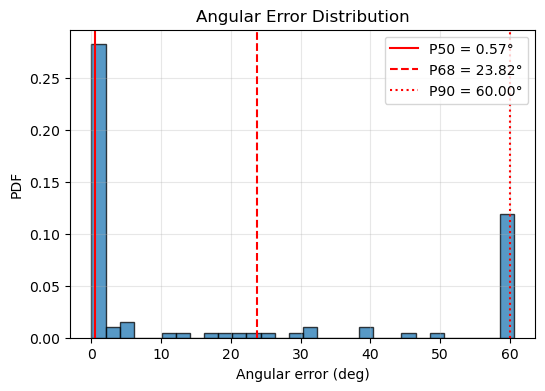

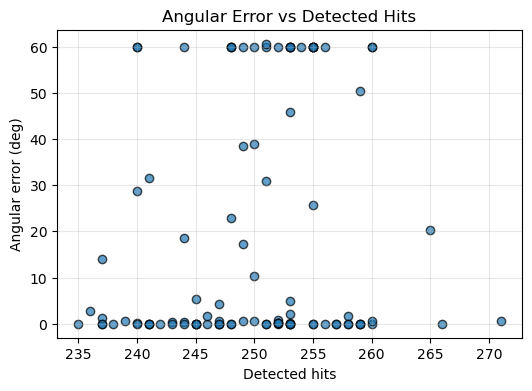

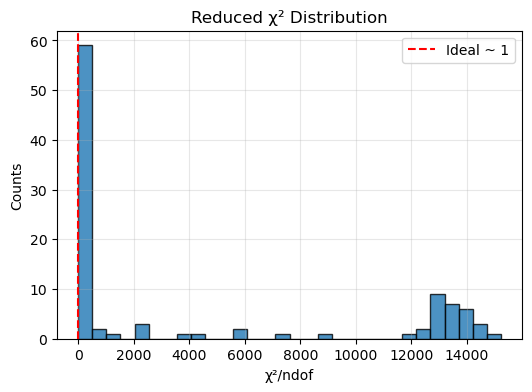

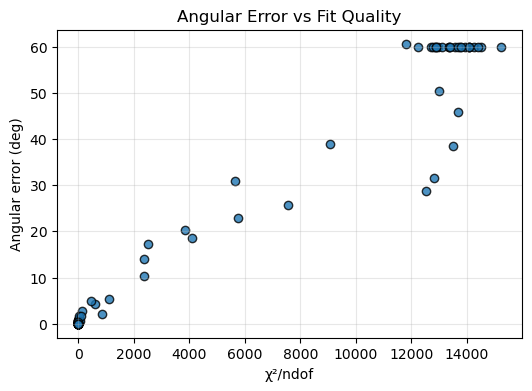

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# ---- helpers ----
def angle_deg(u1, u2):
    u1 = u1 / (np.linalg.norm(u1) + 1e-12)
    u2 = u2 / (np.linalg.norm(u2) + 1e-12)
    cosang = float(np.clip(np.dot(u1, u2), -1.0, 1.0))
    return np.degrees(np.arccos(cosang))

# ---- unpack arrays from `results` ----
u_true   = u  # from your sim
u_hats   = np.array([r["u_hat"] for r in results])
ang_err  = np.array([angle_deg(u_true, ui) for ui in u_hats])
# chi2_red = np.array([r["chi2"] / r["ndof"] for r in results])
chi2_red = np.array([r["chi2_time"] / r["ndof_time"]
                     for r in results
                     if r.get("success", False) and r["ndof_time"] > 0])

n_hits   = np.array([r["detected_hits"] for r in results])
sumK     = np.array([r["sumK"] for r in results])
gain     = np.array([r["a_hat"] for r in results])

# ---- 1) Angular error histogram (your “resolution”) ----
p50, p68, p90 = np.percentile(ang_err, [50, 68, 90])
plt.figure(figsize=(6,4))
plt.hist(ang_err, bins=30, density=True, alpha=0.75, edgecolor='k')
for val, lbl, ls in [(p50,'P50','-'), (p68,'P68','--'), (p90,'P90',':')]:
    plt.axvline(val, color='r', linestyle=ls, label=f'{lbl} = {val:.2f}°')
plt.xlabel('Angular error (deg)'); plt.ylabel('PDF')
plt.title('Angular Error Distribution'); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# # ---- 2) Angular error CDF (68% / 90% containment at a glance) ----
# plt.figure(figsize=(6,4))
# xs = np.sort(ang_err); cdf = np.arange(1, len(xs)+1)/len(xs)
# plt.plot(xs, cdf, lw=2)
# plt.axhline(0.68, color='r', ls='--'); plt.axhline(0.90, color='r', ls=':')
# plt.xlabel('Angular error (deg)'); plt.ylabel('CDF')
# plt.title('Angular Error CDF'); plt.grid(alpha=0.3)
# plt.show()

# ---- 3) Error vs detected hits (does more light help?) ----
plt.figure(figsize=(6,4))
plt.scatter(n_hits, ang_err, alpha=0.7, edgecolor='k')
plt.xlabel('Detected hits'); plt.ylabel('Angular error (deg)')
plt.title('Angular Error vs Detected Hits'); plt.grid(alpha=0.3)
plt.show()

# # ---- 4) Error vs total counts (ΣK), colored by χ²/ndof ----
# plt.figure(figsize=(6,4))
# sc = plt.scatter(sumK, ang_err, c=chi2_red, cmap='viridis', alpha=0.85, edgecolor='k')
# plt.xlabel('Total counts ΣK'); plt.ylabel('Angular error (deg)')
# plt.title('Angular Error vs ΣK (color = χ²/ndof)')
# cbar = plt.colorbar(sc); cbar.set_label('χ²/ndof')
# plt.grid(alpha=0.3); plt.show()

# ---- 5) Reduced χ² distribution (fit quality) ----
plt.figure(figsize=(6,4))
plt.hist(chi2_red, bins=30, alpha=0.8, edgecolor='k')
plt.axvline(1.0, color='r', ls='--', label='Ideal ~ 1')
plt.xlabel('χ²/ndof'); plt.ylabel('Counts')
plt.title('Reduced χ² Distribution'); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# ---- 6) Angular error vs χ²/ndof (flag outliers) ----
plt.figure(figsize=(6,4))
plt.scatter(chi2_red, ang_err, alpha=0.8, edgecolor='k')
plt.xlabel('χ²/ndof'); plt.ylabel('Angular error (deg)')
plt.title('Angular Error vs Fit Quality'); plt.grid(alpha=0.3)
plt.show()


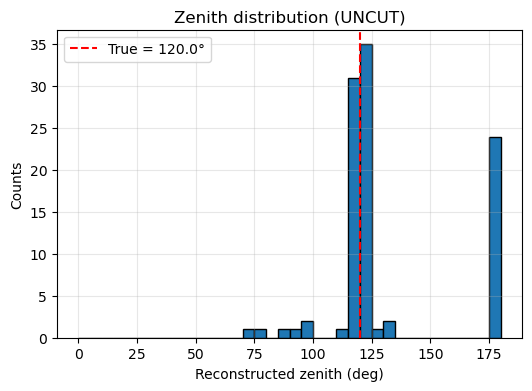

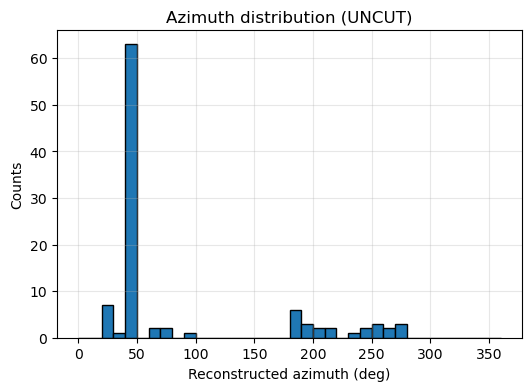

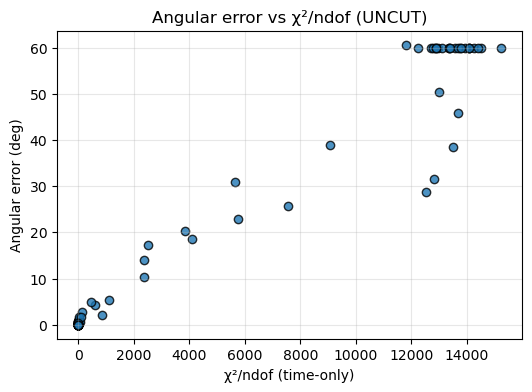

[UNCUT] Events: 100
[UNCUT] Zenith mean/median: 132.81° / 120.00°
[UNCUT] χ²/ndof mean/median: 4359.00 / 10.87


In [139]:
# === Uncut distributions (no chi2 cut) ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# collect all valid reconstructions (uncut)
R_uncut = [r for r in results
           if r.get("success", False)
           and ("chi2_time" in r) and ("ndof_time" in r)
           and np.isfinite(r["chi2_time"]) and (r["ndof_time"] > 0)]

# bail out if nothing valid
if not R_uncut:
    print("No valid (uncut) events to plot.")
else:
    # arrays
    zenith_u  = np.array([r["theta_hat_deg"] for r in R_uncut], float)
    azimuth_u = (np.array([r["phi_hat_deg"] for r in R_uncut], float) + 360.0) % 360.0
    n_hits_u  = np.array([r["detected_hits"] for r in R_uncut], int)
    chi2r_u   = np.array([r["chi2_time"]/r["ndof_time"] for r in R_uncut], float)

    # # --- 1) Reduced chi^2 (time-only) — uncut ---
    # fig, ax = plt.subplots(figsize=(6,4))
    # ax.hist(chi2r_u, bins=30, edgecolor='k', alpha=0.85)
    # ax.axvline(1.0, color='r', ls='--', label='Ideal ~ 1')
    # ax.set_xlabel('χ²/ndof (time-only)')
    # ax.set_ylabel('Counts')
    # ax.set_title('Reduced χ² (UNCUT, time-only)')
    # ax.legend(); ax.grid(alpha=0.3)
    # plt.show()

    # --- 2) Zenith (deg) — uncut ---
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(zenith_u, bins=36, range=(0,180), edgecolor='k')
    ax.axvline(muon_zenith_deg, color='r', ls='--', label=f'True = {muon_zenith_deg:.1f}°')
    ax.set_xlabel('Reconstructed zenith (deg)')
    ax.set_ylabel('Counts')
    ax.set_title('Zenith distribution (UNCUT)')
    # turn off that confusing "+1.2e2" offset on the x-axis
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')
    ax.legend(); ax.grid(alpha=0.3)
    plt.show()

    # --- 3) Azimuth (deg) — uncut ---
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(azimuth_u, bins=36, range=(0,360), edgecolor='k')
    ax.set_xlabel('Reconstructed azimuth (deg)')
    ax.set_ylabel('Counts')
    ax.set_title('Azimuth distribution (UNCUT)')
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')
    ax.grid(alpha=0.3)
    plt.show()

    # --- 4) Angular error vs reduced χ² — uncut (optional) ---
    # if you already have angle_deg(u_true, u_hat) defined:
    def angle_deg(u1, u2):
        u1 = u1 / (np.linalg.norm(u1) + 1e-12)
        u2 = u2 / (np.linalg.norm(u2) + 1e-12)
        cosang = float(np.clip(np.dot(u1, u2), -1.0, 1.0))
        return np.degrees(np.arccos(cosang))

    angerr_u = np.array([angle_deg(u, r["u_hat"]) for r in R_uncut], float)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(chi2r_u, angerr_u, alpha=0.8, edgecolor='k')
    ax.set_xlabel('χ²/ndof (time-only)')
    ax.set_ylabel('Angular error (deg)')
    ax.set_title('Angular error vs χ²/ndof (UNCUT)')
    ax.grid(alpha=0.3)
    plt.show()

    # quick sanity printouts
    print(f"[UNCUT] Events: {len(R_uncut)}")
    print(f"[UNCUT] Zenith mean/median: {zenith_u.mean():.2f}° / {np.median(zenith_u):.2f}°")
    print(f"[UNCUT] χ²/ndof mean/median: {chi2r_u.mean():.2f} / {np.median(chi2r_u):.2f}")


In [135]:
# # From your `results`
# u_true = u  # your simulation truth
# Uhat = np.array([r["u_hat"] for r in results])           # (N,3)
# dot_sign = (Uhat @ u_true)                               # cos(angle to truth), signed
# is_flip = dot_sign < 0                                   # likely 180° inversion
# ang_err = np.array([r for r in (np.degrees(np.arccos(np.clip((Uhat @ u_true),-1,1))))])

# print(f"Total events: {len(results)}")
# print(f"Fraction likely 180° flips: {is_flip.mean():.2%}")
# print("Median error (all)   :", np.median(ang_err))
# print("Median error (noflip):", np.median(ang_err[~is_flip]))
# print("Median error (flips) :", np.median(ang_err[ is_flip]))


***AFTERCUT***


Kept 42/100 events (42.0%) with χ²/ndof ≤ 2.00
Angular error post-cut: mean=0.02°, P50=0.01°, P68=0.02°, P90=0.03°
Reduced χ² post-cut:   median=1.16, mean=1.18


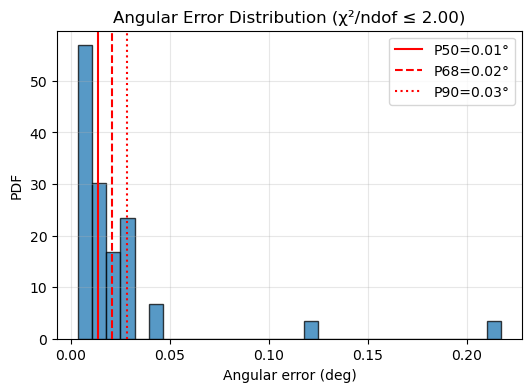

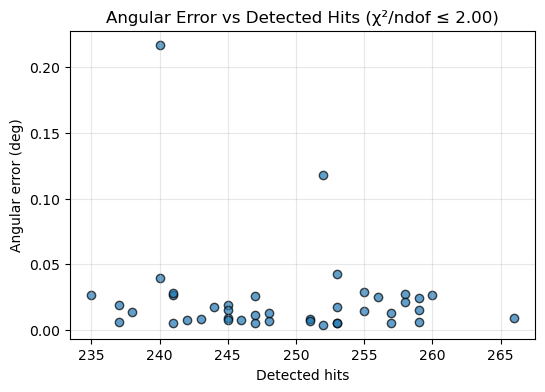

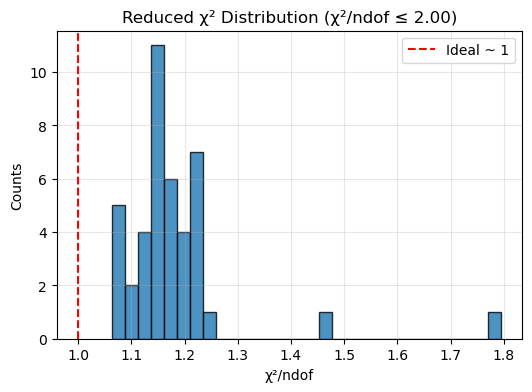

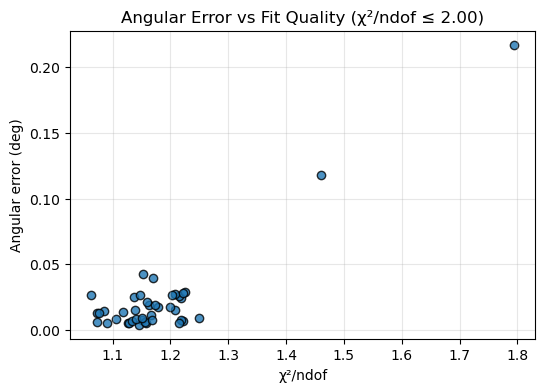

In [131]:
# ============================
# Apply χ²/ndof cut and replot (post-cut only)
# ============================
import numpy as np
import matplotlib.pyplot as plt

# -- helper: angle between two unit vectors (deg)
def angle_deg(u1, u2):
    u1 = u1 / (np.linalg.norm(u1) + 1e-12)
    u2 = u2 / (np.linalg.norm(u2) + 1e-12)
    cosang = float(np.clip(np.dot(u1, u2), -1.0, 1.0))
    return np.degrees(np.arccos(cosang))

# -- extract arrays from results
u_true   = u
u_hats   = np.array([r["u_hat"] for r in results])
ang_err  = np.array([angle_deg(u_true, ui) for ui in u_hats])
chi2_red = np.array([r["chi2_time"] / r["ndof_time"]
                     for r in results
                     if r.get("success", False) and r["ndof_time"] > 0])
n_hits   = np.array([r["detected_hits"] for r in results])
sumK     = np.array([r["sumK"] for r in results])  # not plotted here but handy

# -----------------------------
# Choose ONE cut mode:
# -----------------------------

# Mode A (fixed threshold): keep events with χ²/ndof ≤ thr
thr = 2.0
keep_mask = chi2_red <= thr

# Mode B (percentile): keep best X% by χ²/ndof
# keep_frac = 0.80  # keep best 80%
# thr = np.percentile(chi2_red, 100*keep_frac)
# keep_mask = chi2_red <= thr

# -- guardrail
if keep_mask.sum() == 0:
    print(f"No events pass the cut (χ²/ndof ≤ {thr:.2f}). Loosen the threshold.")
else:
    # quick post-cut stats
    ae = ang_err[keep_mask]
    cr = chi2_red[keep_mask]
    p50, p68, p90 = np.percentile(ae, [50, 68, 90])
    print(f"Kept {keep_mask.sum()}/{len(keep_mask)} events "
          f"({100*keep_mask.mean():.1f}%) with χ²/ndof ≤ {thr:.2f}")
    print(f"Angular error post-cut: mean={ae.mean():.2f}°, "
          f"P50={p50:.2f}°, P68={p68:.2f}°, P90={p90:.2f}°")
    print(f"Reduced χ² post-cut:   median={np.median(cr):.2f}, mean={cr.mean():.2f}")

    title_suffix = f"(χ²/ndof ≤ {thr:.2f})"

    # 1) Angular error histogram
    plt.figure(figsize=(6,4))
    plt.hist(ae, bins=30, density=True, alpha=0.75, edgecolor='k')
    for val, lbl, ls in [(p50,'P50','-'), (p68,'P68','--'), (p90,'P90',':')]:
        plt.axvline(val, color='r', linestyle=ls, label=f'{lbl}={val:.2f}°')
    plt.xlabel('Angular error (deg)'); plt.ylabel('PDF')
    plt.title(f'Angular Error Distribution {title_suffix}')
    plt.legend(); plt.grid(alpha=0.3); plt.show()

    # 3) Angular error vs detected hits
    plt.figure(figsize=(6,4))
    plt.scatter(n_hits[keep_mask], ae, alpha=0.7, edgecolor='k')
    plt.xlabel('Detected hits'); plt.ylabel('Angular error (deg)')
    plt.title(f'Angular Error vs Detected Hits {title_suffix}')
    plt.grid(alpha=0.3); plt.show()

    # 5) Reduced χ² distribution
    plt.figure(figsize=(6,4))
    plt.hist(cr, bins=30, alpha=0.8, edgecolor='k')
    plt.axvline(1.0, color='r', ls='--', label='Ideal ~ 1')
    plt.xlabel('χ²/ndof'); plt.ylabel('Counts')
    plt.title(f'Reduced χ² Distribution {title_suffix}')
    plt.legend(); plt.grid(alpha=0.3); plt.show()

    # 6) Angular error vs reduced χ²
    plt.figure(figsize=(6,4))
    plt.scatter(cr, ae, alpha=0.8, edgecolor='k')
    plt.xlabel('χ²/ndof'); plt.ylabel('Angular error (deg)')
    plt.title(f'Angular Error vs Fit Quality {title_suffix}')
    plt.grid(alpha=0.3); plt.show()


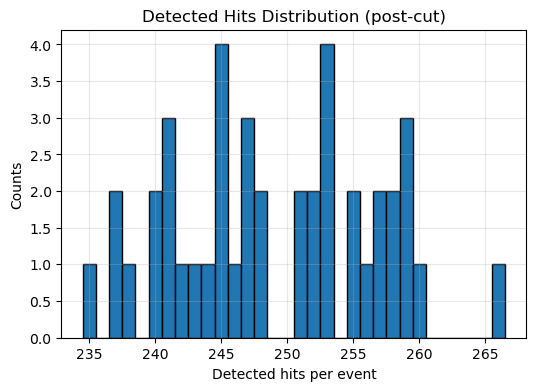

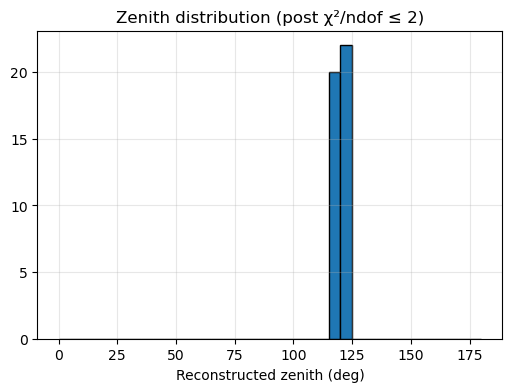

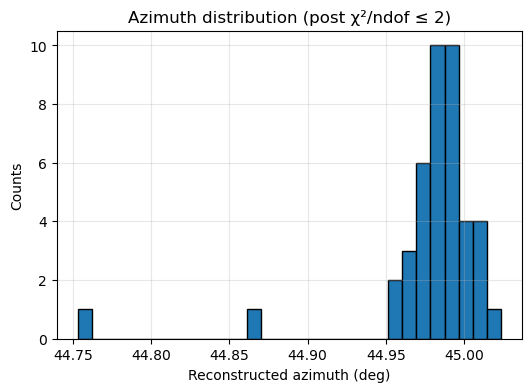

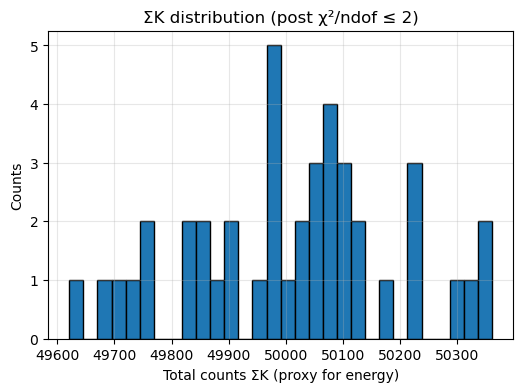

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# -------- helpers to read old/new result dicts ----------
def chi2_red_of(r):
    if "chi2_time" in r and "ndof_time" in r:
        return r["chi2_time"] / max(r["ndof_time"], 1)
    if "chi2" in r and "ndof" in r:
        return r["chi2"] / max(r["ndof"], 1)
    return np.nan

def get_angle_deg(r, base):  # base="theta" or "phi"
    if f"{base}_hat_deg" in r:  return r[f"{base}_hat_deg"]
    if f"{base}_hat_rad" in r:  return np.degrees(r[f"{base}_hat_rad"])
    return np.nan


# --- extract arrays with fallbacks ---
chi2_red = np.array([r["chi2_time"] / r["ndof_time"]
                     for r in results
                     if r.get("success", False) and r["ndof_time"] > 0])
mask_finite = np.isfinite(chi2_red)

zenith = np.array([get_angle_deg(r, "theta") for r in results])[mask_finite]
azimuth = (np.array([get_angle_deg(r, "phi") for r in results])[mask_finite] + 360) % 360
sumK   = np.array([r.get("sumK", np.nan) for r in results])[mask_finite]
a_hat  = np.array([r.get("a_hat", np.nan) for r in results])[mask_finite]
n_hits = np.array([r.get("detected_hits", np.nan) for r in results])[mask_finite]
chi2_red = chi2_red[mask_finite]

# apply the same quality cut you used elsewhere
thr = 2.0
keep = np.isfinite(chi2_red) & (chi2_red <= thr)

# --- example plot: detected hits distribution (post-cut) ---
plt.figure(figsize=(6,4))
bins = np.arange(np.nanmin(n_hits[keep]) - 0.5, np.nanmax(n_hits[keep]) + 1.5)
plt.hist(n_hits[keep], bins=bins, edgecolor='k')
plt.xlabel('Detected hits per event'); plt.ylabel('Counts')
plt.title('Detected Hits Distribution (post-cut)')
plt.grid(alpha=0.3); plt.show()

# -------- extract & cut ----------
chi2_red = np.array([chi2_red_of(r) for r in results])
mask = np.isfinite(chi2_red) & (chi2_red <= 2.0)

zenith = np.array([get_angle_deg(r, "theta") for r in results])[mask]
azimuth = (np.array([get_angle_deg(r, "phi") for r in results])[mask] + 360) % 360
sumK   = np.array([r.get("sumK", np.nan) for r in results])[mask]  # energy proxy

# -------- plots ----------
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(zenith, bins=36, range=(0,180), edgecolor='k')
ax.set_xlabel('Reconstructed zenith (deg)')
ax.set_title('Zenith distribution (post χ²/ndof ≤ 2)')
ax.ticklabel_format(useOffset=False, style='plain', axis='x')  # << no "+1.2e2"
ax.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(6,4))
plt.hist(azimuth, bins=30, edgecolor='k')
plt.xlabel('Reconstructed azimuth (deg)'); plt.ylabel('Counts')
plt.title('Azimuth distribution (post χ²/ndof ≤ 2)'); plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(6,4))
plt.hist(sumK, bins=30, edgecolor='k')
plt.xlabel('Total counts ΣK (proxy for energy)'); plt.ylabel('Counts')
plt.title('ΣK distribution (post χ²/ndof ≤ 2)'); plt.grid(alpha=0.3); plt.show()
